# Building a prediction model for users' responsiveness to Starbucks offers

## Project definition

This notebook will form part of my submission for the capstone project of Udacity's Data Scientist Nanodegree Program. Students were provided with simulated data that mimics customer behavior on the Starbucks rewards mobile app. It is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Once every few days, an offer is sent out to some users of the Starbucks app. We were provided information on the various types of offers, as well as information on the user base. In addition, we were given a log of events relating to users' interaction with offers and their transactions. 

With the given data, I aim to **build a model that predicts whether a user will respond to an offer that he/she receives**. In other words, given a combination of offer features and user characteristics, we want our model to be able to predict the likelihood of such a user making a transaction as a result of the offer. I structured the notebook in the following manner
- Project definition (current section)
- Data exploration and visualisation
- Data preprocessing
- Model building and evaluation
- Conclusion

## Data exploration and visualisation

First, we import and load in the data provided

In [1]:
import pandas as pd
import numpy as np
import math
import json
import itertools
import matplotlib.pyplot as plt
from workspace_utils import active_session
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### (a) Offers data

Information provided by Udacity:

**portfolio.json** - containing offer ids and meta data about each offer (duration, type, etc.)
* **id** (string) - offer id
* **offer_type** (string) - type of offer ie BOGO, discount, informational
* **difficulty** (int) - minimum required spend to complete an offer
* **reward** (int) - reward given for completing an offer
* **duration** (int) - time for offer to be open, in days
* **channels** (list of strings)

From the data below, we took note of the following:
- 10 distinct offers
- 3 distinct offer types - buy-one-get-one, discount, and informational offers. We will encode this information as dummy variables if required as a model input. Intuitively, we'd expect the type of offer to influence how likely a customer will respond to it (for example, BOGO offers may seem more attractive)
- an offer may be distributed through one or more of 4 distinct channels. Again, we will probably create a dummy variable for each channel for input into a model


In [2]:
# portfolio['reward_share'] = portfolio['reward']/portfolio['difficulty']
portfolio.sort_values(by='offer_type')

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0


### (b) Customer profile data

Information provided by Udacity:

**profile.json** - demographic data for each customer
* **age** (int) - age of the customer 
* **became_member_on** (int) - date when customer created an app account
* **gender** (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* **id** (str) - customer id
* **income** (float) - customer's income

In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


There are 17,000 unique customers

In [8]:
print("no. of unique customers: {}".format(len(profile['id'].unique()))) # no. of unique customers

no. of unique customers: 17000


An unusual no. of customers are aged 118, which implies that age data for these customers were not collected. Otherwise, the 50-60 age range seems to be most well-represented among customers.

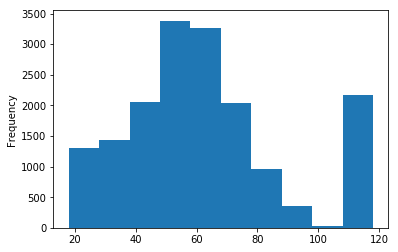

In [9]:
profile['age'].plot(kind='hist')

In [10]:
profile['age'].value_counts().head(10)

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
Name: age, dtype: int64

There are about 33% more male than female customers, with a small proportion identifying as 'other'.
2175 (13%) customers have missing gender data. Upon further inspection, it seems like customers with missing gender data are exactly those who are aged 118, and have missing income data as well. 

We add a dummy variable to identify these customers - the lack of data could be a reflection of some kind of systematic bias in the profile of these customers.

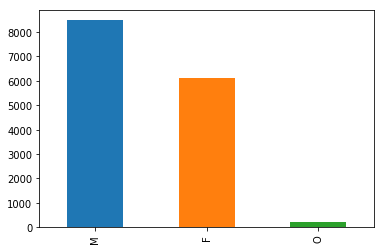

In [11]:
profile['gender'].value_counts().plot(kind='bar')

In [12]:
# no. of customers with missing gender data
print(len(profile[profile['gender'].isnull()]))
# no. of customers with missing income data
print(len(profile[profile['income'].isnull()]))
# no. of customers with missing age data
print(len(profile[profile['age']==118]))
# Customers with missing gender data also have missing income data and are aged 118
len(profile[profile['gender'].isnull()]) == len(profile[(profile['gender'].isnull()) & (profile['income'].isnull()) & (profile['age']==118)])

2175
2175
2175


True

In [3]:
profile['is_missing_data'] = profile['gender'].isnull()*1  # add a flag for those customers that lack data for across those 3 columns

To further explore the `became_member_on` column, we can convert it to datetime. When we visualise how many members joined per month, there appears to be 4 distinct phases:
- Aug 2013 - Jul 2015: **50-70** new members/month
- Aug 2015 - June 2017: **250-350** new members/month
- Aug 2017 - Jan 2018: **800-900** new members/month
- Feb 2018 - Jul 2018: **500-600** new members/month
These could be potentially be linked to how aggressive new user acquisition campaigns were; for example, Starbucks could have attracted the highest number of new joiners from Aug 2017 to Jan 2018 because it marketed its rewards programme across many different channels and dangled very attractive new user discounts.

In [3]:
type(profile['became_member_on_month'].value_counts())

pandas.core.series.Series

Text(0,0.5,'No. of new members per month')

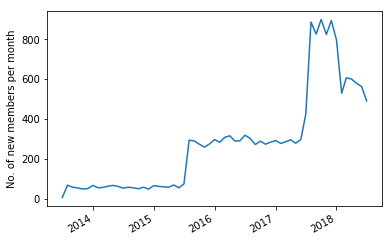

In [7]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
# profile['became_member_on_year'] = profile['became_member_on'].dt.year
# profile['became_member_on_month'] = profile['became_member_on'].dt.month
profile['became_member_on_month'] = profile['became_member_on'] + pd.offsets.MonthBegin(-1)
profile['became_member_on_month'].value_counts().plot()
plt.ylabel('No. of new members per month')

There is no systematic bias in the membership start dates of customers with missing data

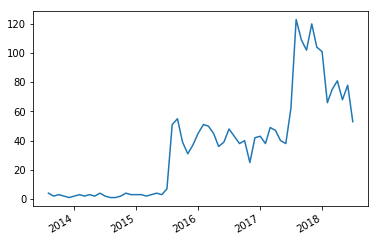

In [15]:
profile[profile.is_missing_data==1]['became_member_on_month'].value_counts().plot()

### (c) Transcript data

Information provided by Udacity:

**transcript.json** - records for transactions, offers received, offers viewed, and offers completed
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

We took note of the following:
- this is a log of every event-customer-time combination that occured during the period
- there are 4 unique events - transaction, offer received, offer viewed and offer completed.

In [11]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [16]:
# distribution of events
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

We visualise how many times each event occurs over time, to get a sense of how often each event occurs relative to each other and how they are distributed across time. There are 6 distinct instances at which offers were received, which naturally results in a spike in offers viewed/completed that decays gradually over the next few days.

Text(0,0.5,'No. of occurrences')

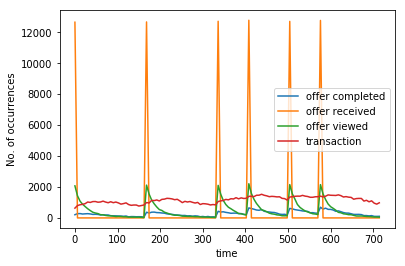

In [8]:
event_time_count = transcript.groupby(['time','event']).count()['person'].reset_index()
event_time_count.columns = ['time','event','count']

# not all events occur at each time, so we extend the dataframe to capture all time-event combinations
list_time = list(event_time_count.time.unique())
list_event = list(event_time_count.event.unique())
event_time_comb = pd.DataFrame(list(itertools.product(*[list_time, list_event])), columns=['time','event'])
event_time_count2 = pd.merge(event_time_count, event_time_comb, how='right', on=['time','event']).sort_values(by=['time','event'])
event_time_count2 = event_time_count2.fillna(0).set_index('time')
event_time_count2.groupby('event')['count'].plot(legend=True)
plt.ylabel('No. of occurrences')

The **value** column contains information that varies depending on the event type. 
- offer received: offer_id
- offer viewed: offer_id
- offer completed: offer_id, reward
- transaction: amount

In [18]:
print(transcript[transcript.event=='offer received'].value.iloc[0])
print(transcript[transcript.event=='offer viewed'].value.iloc[0])
print(transcript[transcript.event=='offer completed'].value.iloc[0])
print(transcript[transcript.event=='transaction'].value.iloc[0])

{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}
{'amount': 0.8300000000000001}


To facilitate data wrangling, we can split the column up into multiple columns that each contain the same type of information, namely **offer_id**, **reward**, **amount**

In [19]:
# expand "value" column into multiple columns each containing a specific type of information 
transcript2 = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
# combine "offer_id" and "offer id" columns by choosing the value from the column that is not NaN
transcript2['offer_id_clean'] = transcript2['offer id'].combine_first(transcript2['offer_id'])
transcript2 = transcript2.drop(['offer id','offer_id'], axis=1).rename(columns={'offer_id_clean':'offer_id'})
transcript2.head()

,event,person,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


We take a look at a single person's events to get a sense of how an **offer completed** event is logged. We see that offer completed events are recorded at the same time as the transaction that completes the offer. However, it is possible for an offer to be logged as completed even if it wasn't viewed before the transaction that results in the offer completion event, as can be seen in the following example:

- At t=510, there are 2 offer completed events, 1 each for offer_id *ae264e3637204a6fb9bb56bc8210ddfd* and *f19421c1d4aa40978ebb69ca19b0e20d*
- Offer *ae264e3637204a6fb9bb56bc8210ddfd* was viewed before the offer completion event; offer *f19421c1d4aa40978ebb69ca19b0e20d* was viewed after.

Intuitively, only the first offer could've led to a change in customer behaviour as the offer was viewed before the qualifying transaction, so we would consider the customer to have responded to the offer in the first case (he viewed the offer and made a transaction within the offer validity period), but not the second case (he transacted without viewing the offer).

In [21]:
transcript2[transcript2.person=='78afa995795e4d85b5d9ceeca43f5fef']

,event,person,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89},19.89,NaN,NaN
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78},17.78,NaN,NaN
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67},19.67,NaN,NaN
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72},29.72,NaN,NaN
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93},23.93,NaN,NaN


In addition, there are no offer completed events associated with offer_id's of informational offers.

In [27]:
# merge transcript of events with offer features
transcript3 = pd.merge(transcript2, portfolio[['offer_id','duration','offer_type']], how='outer', on='offer_id').drop('value',axis=1)
# transcript3.to_csv("transcript3.csv")

# offer received events were evenly distributed across all 10 offers
transcript3[transcript3.event=='offer received'].groupby(['offer_id','duration','offer_type']).size().reset_index(name='count')

,offer_id,duration,offer_type,count
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,10.0,discount,7668
1,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,discount,7646
2,2906b810c7d4411798c6938adc9daaa5,7.0,discount,7632
3,3f207df678b143eea3cee63160fa8bed,4.0,informational,7617
4,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,bogo,7593
5,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,7618
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,7677
7,ae264e3637204a6fb9bb56bc8210ddfd,7.0,bogo,7658
8,f19421c1d4aa40978ebb69ca19b0e20d,5.0,bogo,7571
9,fafdcd668e3743c1bb461111dcafc2a4,10.0,discount,7597


In [8]:
# no offer completed events logged for informational offers
transcript3[transcript3.event=='offer completed'].groupby(['offer_id','duration','offer_type']).size().reset_index(name='count')

,offer_id,duration,offer_type,count
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,10.0,discount,3420
1,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,discount,5156
2,2906b810c7d4411798c6938adc9daaa5,7.0,discount,4017
3,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,bogo,3331
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,4354
5,ae264e3637204a6fb9bb56bc8210ddfd,7.0,bogo,3688
6,f19421c1d4aa40978ebb69ca19b0e20d,5.0,bogo,4296
7,fafdcd668e3743c1bb461111dcafc2a4,10.0,discount,5317


However, we can see in the following example that the customer made a transcation after receiving and viewing an informational offer. Hence, we conclude that there is at least one informational offer that was effective and the lack of such data could be the result of systematic errors in data collection.

In [10]:
transcript3[transcript3.person=='c27e0d6ab72c455a8bb66d980963de60'].sort_values(by='time').head()

,event,person,time,amount,reward,offer_id,duration,offer_type
123454,offer received,c27e0d6ab72c455a8bb66d980963de60,0,NaN,NaN,3f207df678b143eea3cee63160fa8bed,4.0,informational
125006,offer viewed,c27e0d6ab72c455a8bb66d980963de60,18,NaN,NaN,3f207df678b143eea3cee63160fa8bed,4.0,informational
169862,transaction,c27e0d6ab72c455a8bb66d980963de60,18,13.25,NaN,NaN,NaN,NaN
178936,transaction,c27e0d6ab72c455a8bb66d980963de60,72,18.90,NaN,NaN,NaN,NaN
190271,transaction,c27e0d6ab72c455a8bb66d980963de60,144,20.20,NaN,NaN,NaN,NaN


In [29]:
transcript3['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

**Key insight**: in determining whether a customer responded to a received offer, we cannot directly make of the the given records of "offer completed" events. Further data preprocessing is needed in order to achieve that

## Data preprocessing

**Problem statement**: build a model that predicts whether a user will respond to an offer that he/she receives

Our preprocessing steps will be guided by the above problem statement. We will build a classifier that tells us whether a customer will respond to an offer, based on the customer's profile as well as offer characteristics. 

In order to train such a model, we would need a labelled dataset that indicates whether each received offer is effective or not. We define a received offer to be effective if it has fulfilled the following criteria:
1. it was viewed within the offer validity period
2. a transaction was made within the offer validity period
3. (2) did not occur earlier than (1)

### Transcript data - labelling each received offer as effective or not

In [2]:
# transcript3 = pd.read_csv('transcript3.csv',index_col=0)
transcript3.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,event,person,time,amount,reward,offer_id,duration,offer_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo


First, we create a dataframe in which each row represents a unique offer received event.

In [6]:
df_offer_rec = transcript3[transcript3.event=='offer received'].copy()
df_offer_rec.head()

,event,person,time,amount,reward,offer_id,duration,offer_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo


For each received offer, we generate columns that tell us
- whether the offer was viewed by the user within the offer validity period
- the earliest time at which the offer was viewed by the user, if applicable

In [18]:
# transcript of only 'offer viewed' events, to reduce time taken to parse this df
df_offer_views = transcript3[transcript3.event=='offer viewed'].copy()

def was_offer_viewed(i):
    """Looks at a given row of df_offer_views, returns tuple indicating whether the offer was viewed by the user, 
    and the earliest time it was viewed
    
    Args: 
        i (int): index of df_offer_rec
    Returns:
        is_viewed (int): 1 if offer was viewed within offer validity period, 0 otherwise
        viewed_time (int): earliest time at which offer was viewed, NaN if offered was not viewed
    """
    person = df_offer_rec['person'][i]
    offer_id = df_offer_rec['offer_id'][i]
    time = df_offer_rec['time'][i]
    duration = df_offer_rec['duration'][i]*24
    df = df_offer_views[(df_offer_views.person==person) & 
                          (df_offer_views.offer_id==offer_id) & 
                          (df_offer_views.time>=time) & (df_offer_views.time<=time+duration)].sort_values(by='time')
    if len(df)>0:
        is_viewed = 1
        viewed_time = df['time'].iloc[0] # take earliest time at which offer was viewed
    else:
        is_viewed = 0
        viewed_time = np.nan
        
    return is_viewed, viewed_time

with active_session():
    view_time = list(map(was_offer_viewed, df_offer_rec.index))
    df_offer_rec['offer_viewed'] = [tpl[0] for tpl in view_time]
    df_offer_rec['offer_viewed_time'] = [tpl[1] for tpl in view_time]
    
# df_offer_rec.to_csv('offer_rec.csv')

Next, we create additional columns that show
- whether the user transacted during the offer validity period
- the time of the latest transaction, if applicable

In [50]:
# transcript of only 'transaction' events, to reduce time taken to parse this df
df_txn = transcript3[transcript3.event=='transaction']

def had_valid_txn(i):
    """Looks at a given row of df_offer_views, returns tuple indicating whether there was a transaction within the offer validity period,
    and the time of the latest such transaction
    
    Args: 
        i (int): index of df_offer_rec
    Returns:
        had_txn (int): 1 if user transacted within offer validity period, 0 otherwise
        txn_time (int): time of latest transaction, NaN if offer was not viewed
    """
    person = df_offer_rec['person'][i]
    offer_id = df_offer_rec['offer_id'][i]
    time = df_offer_rec['time'][i]
    duration = df_offer_rec['duration'][i]*24
    df = df_txn[(df_txn.person==person) & 
                          (df_txn.time>=time) & (df_txn.time<=time+duration)].sort_values(by='time', ascending=False)
    if len(df)>0:
        had_txn = 1
        txn_time = df['time'].iloc[0] # take time of latest transaction
    else:
        had_txn = 0
        txn_time = np.nan
    
    return had_txn, txn_time
    
with active_session():
    txn_time = list(map(had_valid_txn, df_offer_rec.index))
    df_offer_rec['had_txn'] = [tpl[0] for tpl in txn_time]
    df_offer_rec['txn_time'] = [tpl[1] for tpl in txn_time]

# df_offer_rec.to_csv('offer_rec_v2.csv')

Finally, we label each offer as being effective or not based on the aforementioned criteria. It turns out that of the ~76k offers received, about 57% of those were effective (i.e. were viewed and subsequently had a valid transaction within the offer period)

In [2]:
df_offer_rec = pd.read_csv('offer_rec_v2.csv', index_col=0)
df_offer_rec['is_effective_offer'] = df_offer_rec['offer_viewed']*df_offer_rec['had_txn']*(df_offer_rec['txn_time']>=df_offer_rec['offer_viewed_time'])
df_offer_rec.head()

,event,person,time,amount,reward,offer_id,duration,offer_type,offer_viewed,offer_viewed_time,had_txn,txn_time,is_effective_offer
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,1,6.0,1,144.0,1
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,0,NaN,1,60.0,0
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,1,48.0,1,138.0,1
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,1,30.0,1,66.0,1
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo,0,NaN,0,NaN,0


In [4]:
df_offer_rec.drop(['amount','reward','offer_type'], axis=1)

,event,person,time,offer_id,duration,offer_viewed,offer_viewed_time,had_txn,txn_time,is_effective_offer
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,1,6.0,1,144.0,1
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,0,NaN,1,60.0,0
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,1,48.0,1,138.0,1
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,1,30.0,1,66.0,1
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,0,NaN,0,NaN,0
5,offer received,a3b9b4bf115e4564933ea2e4bc936843,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,1,18.0,1,144.0,1
6,offer received,32fbf97e89274e8a935903f2ad095e1f,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,1,96.0,1,156.0,1
7,offer received,52f0bd64403f4958ab8fe9a6947c13c3,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,0,NaN,1,168.0,0
8,offer received,d41fa9b8c2e24a1d94caa890c53bbcf6,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,0,NaN,0,NaN,0
9,offer received,c099206f76b1414db7552f163520053c,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,1,0.0,1,102.0,1


In [3]:
print("share of received offers viewed: {}".format(df_offer_rec['offer_viewed'].sum()/len(df_offer_rec)))
print("share of received offers which had a transaction within the offer validity period: {}".format(df_offer_rec['had_txn'].sum()/len(df_offer_rec)))
print("share of received offers which were effective: {}".format(df_offer_rec['is_effective_offer'].sum()/len(df_offer_rec)))

share of received offers viewed: 0.7458998125254008
share of received offers which had a transaction within the offer validity period: 0.78597742438743
share of received offers which were effective: 0.574327779015955


In [4]:
len(df_offer_rec)

76277

### Offers data

Next, we do some preprocessing of the table containing information on each offer. We introduce dummy columns for the categorical variables `channels` and `offer_type`. 

In [5]:
portfolio2 = portfolio.copy()

# dummy columns for channels
portfolio2['web'] = [1 if 'web' in lst else 0 for lst in portfolio['channels']]
portfolio2['email'] = [1 if 'email' in lst else 0 for lst in portfolio['channels']]
portfolio2['social'] = [1 if 'social' in lst else 0 for lst in portfolio['channels']]
portfolio2['mobile'] = [1 if 'mobile' in lst else 0 for lst in portfolio['channels']]
# dummy columns for offer_type
portfolio2 = pd.concat([portfolio2, pd.get_dummies(portfolio2['offer_type'], drop_first=True)], axis=1)

portfolio2 = portfolio2.rename(columns={'id':'offer_id'})
portfolio2.head()

,channels,difficulty,duration,offer_id,offer_type,reward,web,email,social,mobile,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0,1,0


### Profile data

We also run the following preprocessing steps on the customer profile data
- fill NaN's in `income` column with 0's
- create dummies for `gender`
- engineer a new feature named `days_as_member` that captures the membership length of each user in days (as of 26 July 2018)

In [6]:
profile2 = profile.copy()

# replace NaN's in income column with 0's
profile2['income'] = profile2['income'].fillna(0)

# dummy columns for gender
profile2 = pd.concat([profile2, pd.get_dummies(profile['gender'])], axis=1).drop('O', axis=1)

# convert became_member_on column to an integer column with the length of membership as of 26 Jul 2018, in days
profile2['days_as_member'] = (profile.became_member_on.max() - profile.became_member_on).dt.days
profile2 = profile2.rename(columns={'id':'person'})
profile2.head()

,age,became_member_on,gender,person,income,is_missing_data,became_member_on_month,F,M,days_as_member
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,0.0,1,2017-02-01,0,0,529
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,2017-07-01,1,0,376
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,0.0,1,2018-07-01,0,0,14
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,2017-05-01,1,0,443
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,0.0,1,2017-08-01,0,0,356


### Putting all the data together

We join the following data frames together:
- `df_offer_rec`: contains every received offer and whether the customer responded to the offer
- `portfolio2`: contains the features of each offer
- `profile2`: contains deomgraphic information of each customer

The resulting data frame contains all the information we need to train a model to predict whether an offer will be effective.
- target variable: is_effective_offer
- predictor variables: remaining columns that describe the offer and the customer's profile

In [17]:
# join tables
df1 = pd.merge(df_offer_rec.drop(['duration','offer_type','reward','duration','amount'],axis=1), portfolio2, on='offer_id')
df2 = pd.merge(df1, profile2, on='person')
# preserve only numerical columns containing relevant features
df2 = df2.drop(['person','offer_id','event','time','offer_viewed', 'offer_viewed_time', 'had_txn', 'txn_time',
                'channels','offer_type','gender','became_member_on','became_member_on_month'], axis=1)
df2.head()

,is_effective_offer,difficulty,duration,reward,web,email,social,mobile,discount,informational,age,income,is_missing_data,F,M,days_as_member
0,1,5,7,5,1,1,0,1,0,0,75,100000.0,0,1,0,443
1,0,5,5,5,1,1,1,1,0,0,75,100000.0,0,1,0,443
2,1,10,7,10,0,1,1,1,0,0,75,100000.0,0,1,0,443
3,1,0,3,0,0,1,1,1,0,1,75,100000.0,0,1,0,443
4,0,5,7,5,1,1,0,1,0,0,59,41000.0,0,0,1,1282


In [18]:
# df2.to_csv('data_preproc.csv')

## Model building and evaluation

As the outcome variable is binary, we will train classification models to predict whether an offer is effective. 

We will **evaluate model performance using the F1-score**, since both precision and recall have important implications
- recall: we want to identify as many user-offer combinations that will result in the user responding to the offer
- precision: we don't want to have too many false positives, as that could lead to users being overwhelmed with too many offers, which could annoy users and dampen the effectiveness of other offers

First, we create train-test splits of the target and predictor variables. 

In [2]:
# df2 = pd.read_csv('data_preproc.csv', index_col=0)
X = df2.drop('is_effective_offer',axis=1)
y = df2.is_effective_offer
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Decision Tree

We first fit a decision tree classifier on the train set. Using the default model parameters, we get an F1-score of 0.69.

In [21]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.59      0.63      0.61      8145
          1       0.71      0.68      0.69     10925

avg / total       0.66      0.65      0.66     19070



Next, we try using a random forest classifier, and the F1-score improves to 0.72. A random forest is likely to perform better than a decision tree as it is much less prone to overfitting (many trees fitted vs one tree).

In [22]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.63      0.65      0.64      8145
          1       0.73      0.71      0.72     10925

avg / total       0.69      0.69      0.69     19070



The F1-score could further improve if we are able to select more optimal parameters for the random forest. We use `GridSearchCV` to find a better-performing set of parameters. Setting `max_depth=10`, `min_samples_leaf=1` and `n_estimators=200` helps to improve the F1-score to 0.76

In [12]:
param_grid_rf = {
    'n_estimators': [10,50,100,200],
    'min_samples_leaf': [1,2,5,10,20],
    'max_depth': [5,10,20]
}
cv_rf = GridSearchCV(RandomForestClassifier(random_state=1), param_grid=param_grid_rf, scoring='f1')
cv_rf.fit(X_train, y_train)
cv_rf.best_params_

{'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200}

In [13]:
print(classification_report(y_test, cv_rf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.68      0.66      0.67      8145
          1       0.75      0.77      0.76     10925

avg / total       0.72      0.72      0.72     19070



In [13]:
rf_final = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators=200, random_state=1)
rf_final.fit(X_train, y_train)
y_pred = rf_final.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.68      0.66      0.67      8145
          1       0.75      0.77      0.76     10925

avg / total       0.72      0.72      0.72     19070



The features importances from the best-performing model suggest that the following features are the most useful in predicting whether an offer will be effective:
- whether the offer is distributed through the "social" channel
- user's membership length

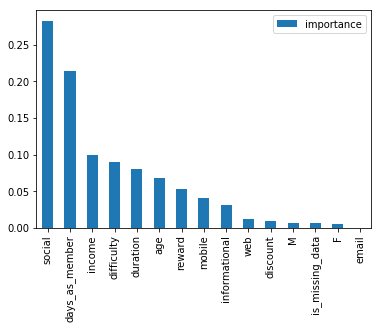

In [14]:
feat_imp = pd.DataFrame(rf_final.feature_importances_,
                        index = X.columns,
                        columns=['importance']).sort_values('importance',ascending=False)
feat_imp.plot.bar()

### KNN

We evaluate whether a non-tree-based model such as k-nearest neighbours could outperform a random forest. The default KNN setting gives us an F1-score of 0.68, lower than our best score using random forests.

In [3]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.55      0.45      0.49      8145
          1       0.64      0.72      0.68     10925

avg / total       0.60      0.61      0.60     19070



Similarly, we use grid search to further optimise the KNN model parameters. The best KNN model returns an F1-score of 0.69, underperforming the best random forest model. One reason KNN may not work well could be that it does not differentiate between the more predictive features and the less predictive ones. For example, assuming we don't explicitly manipulate the KNN weights, the algorithm will treat all normalized features as "equal" in importance. On the other hand, each feature can have varying levels of importance in a random forest, as shown above in the chart.

In [10]:
param_grid_knn = {
    'n_neighbors': [5,7,11,15,21],
    'weights':['uniform','distance']
}
cv_knn = GridSearchCV(KNeighborsClassifier(n_jobs=-1), param_grid=param_grid_knn, scoring='f1')
cv_knn.fit(X_train, y_train)
cv_knn.best_params_

{'n_neighbors': 21, 'weights': 'uniform'}

In [11]:
print(classification_report(y_test, cv_knn.predict(X_test)))

             precision    recall  f1-score   support

          0       0.56      0.39      0.46      8145
          1       0.63      0.77      0.69     10925

avg / total       0.60      0.61      0.59     19070



## Conclusion

We started out with this aim - to build a model that predicts whether a user will respond to an offer that he/she receives. After exploring the data and doing the necessary data preprocessing, we tried several different models and evaluated their performance. Our final recommendation is to use a random forest model with parameters `max_depth=10`, `min_samples_leaf=1` and `n_estimators=200`, as it had the highest F1-score of 0.76.

### Difficulties
Data preprocessing was the most difficult task in this analysis. On the surface, the dataset given seemingly had what we wanted - whether offers were effective or not. Upon closer inspection though, we realised that we could not rely on the "offer completed" events and had to work out a way to identify which received offers were effective. It was a tedious process that required a non-trivial amount of computing time, which we attempted to cut down by reducing the size of the data frame that we have to search through each time.

### Areas of improvement
Intuitively, one factor that could affect the effectiveness of an offer could be the time of day (or week). For example, an offer received during lunchtime on weekdays, when the average office worker is perhaps more likely to be on the phone, could have a higher probability of being viewed. In addition, it could also have a higher probability of leading to a purchase as people do like to have coffee after meals. Hence, we could have added a feature that tells us which hour of day (or week) the offer was received.

Another improvement we could have made would be to try out other types of classification models such as logistic regression, or more sophisticated ones such as neural networks. The logistic regression coefficients could help us quantify how each feature affects the likelihood of the offer being effective. Multi-layer neural networks are able to capture very complex relationships and could potentially also help us to improve precision and recall, but are harder to interpret and explain (e.g. we will not know how important each feature is).